# AR Survey: Comparing Field Geometry and AIA Emission

In [21]:
import os
import io
import glob
import urllib
import datetime
import warnings
warnings.filterwarnings('ignore')

import pandas
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import astropy.constants as const
import astropy.table
from astropy.coordinates import SkyCoord
from sunpy.sun import constants
from sunpy.map import Map
from sunpy.net import Fido,attrs as a
from sunpy.time import TimeRange

import synthesizAR
import synthesizAR.extrapolate
from synthesizAR.util import heeq_to_hcc_coord

%matplotlib inline

We want to look at the geometry from PFSS field extrapolations of several different observed ARs and compare with the observed emission to see how well they reproduce the actual "loops." We will use the set of 15 ARs originally studied by Warren et al. (2012) and then later by Viall and Klimchuk (2017). We will perform a field extrapolation for each HMI magnetogram and then compare with the corresponding AIA 171 emission.

## AR Catalogue
First we need to pull down the table of AR data from the original Warren et al. (2012) paper. Convert all  of the times to datetimes and the locations to unitful quantities

In [2]:
tmp = (urllib.request.urlopen('http://iopscience.iop.org/0004-637X/759/2/141/suppdata/apj446760t1_ascii.txt')
                     .readlines())
col_names = tmp[3].decode('utf8').strip().split('\t')
raw_table = [t.decode('utf8').strip().split('\t') for t in tmp[4:-3]]
ar_catalogue = pandas.DataFrame(data=raw_table,columns=col_names)
ar_catalogue['Date'] = pandas.to_datetime(ar_catalogue['Date'])
ar_catalogue['X_cen'] = pandas.to_numeric(ar_catalogue['X_cen'])
ar_catalogue['Y_cen'] = pandas.to_numeric(ar_catalogue['Y_cen'])
ar_catalogue = astropy.table.QTable.from_pandas(ar_catalogue)
ar_catalogue['X_cen'].unit = u.arcsec
ar_catalogue['Y_cen'].unit = u.arcsec

In [3]:
ar_catalogue

Region,NOAA,Date,X_cen,Y_cen,A_M,Phi_M,I_hot,alpha,beta,EIS File
,,,arcsec,arcsec,,,,,,
str2,str4,datetime64[ns],float64,float64,str8,str8,str8,str7,str8,str22
1,1082,2010-06-19T01:57:44.000000000,-306.4,439.3,2.87(19),4.08(21),1.36(04),2.2,6.1,eis_l1_20100619_014433
2,1158,2011-02-12T15:32:13.000000000,-248.4,-211.8,3.04(19),4.22(21),1.88(04),2.7,6.8,eis_l1_20110212_143019
3,1082,2010-06-21T01:46:37.000000000,162.9,405.2,3.29(19),4.72(21),1.05(04),2.0,7.8,eis_l1_20100621_011541
4,1259,2011-07-25T09:36:09.000000000,224.7,323.4,3.98(19),5.68(21),7.81(03),2.0,7.7,eis_l1_20110725_090513
5,1150,2011-01-31T11:25:19.000000000,-470.9,-250.6,5.17(19),7.50(21),1.47(05),2.2,8.7,eis_l1_20110131_102326
6,1147,2011-01-21T14:10:50.000000000,26.6,476.5,6.49(19),1.02(22),2.28(05),3.6,8.3,eis_l1_20110121_133954
7,1243,2011-07-02T03:38:08.000000000,-299.0,216.6,6.79(19),1.09(22),6.18(04),2.9,9.0,eis_l1_20110702_030712
8,1089,2010-07-23T15:03:07.000000000,-363.4,-453.6,6.96(19),1.12(22),1.84(05),3.5,9.5,eis_l1_20100723_143210


Now, download a single HMI magnetogram and AIA image for each region at the specified date.

In [ ]:
def convert_npdt_to_str(npdt):
    # assumes ns
    return datetime.datetime.utcfromtimestamp(npdt.astype(datetime.datetime)*1e-9).strftime("%Y/%m/%d %H:%M:%S")

In [ ]:
hmi_files = []
aia_files = []
obs_data_loc = '/storage-home/w/wtb2/data/timelag_synthesis/observational_data/'
for row in ar_catalogue:
    print('Querying data for region #{}'.format(row['Region']))
    ### HMI
    dt = 30*u.s
    q_hmi = Fido.search(
        a.Time(TimeRange(convert_npdt_to_str(row['Date'] - np.timedelta64(int(dt.value),'s')),2*dt)),
        a.Instrument('HMI') & a.vso.Physobs('LOS_magnetic_field')
    )
    print(q_hmi)
    hmi_res = Fido.fetch(q_hmi,path=obs_data_loc)
    hmi_files.append(hmi_res[0])
    ### AIA
    dt = 15*u.s
    q_aia = Fido.search(
        a.Time(TimeRange(convert_npdt_to_str(row['Date'] - np.timedelta64(int(dt.value),'s')),2*dt)),
        a.Instrument('AIA'),
        a.Wavelength(171*u.angstrom,171*u.angstrom)
    )
    print(q_aia)
    aia_res = Fido.fetch(q_aia,path=obs_data_loc)
    aia_files.append(aia_res[0])

Add the map lists to the AR catalogue table.

In [ ]:
ar_catalogue['HMI File'] = hmi_files
ar_catalogue['AIA File'] = aia_files

In [4]:
ar_catalogue['HMI_File'] = [
    '/storage-home/w/wtb2/data/timelag_synthesis/observational_data/hmi_m_45s_2010_06_19_01_58_30_tai_magnetogram.fits',
    '/storage-home/w/wtb2/data/timelag_synthesis/observational_data/hmi_m_45s_2011_02_12_15_33_00_tai_magnetogram.fits',
    '/storage-home/w/wtb2/data/timelag_synthesis/observational_data/hmi_m_45s_2010_06_21_01_47_15_tai_magnetogram.fits',
    '/storage-home/w/wtb2/data/timelag_synthesis/observational_data/hmi_m_45s_2011_07_25_09_36_45_tai_magnetogram.fits',
] + 11 * ['']
ar_catalogue['AIA_File'] = [
    '/storage-home/w/wtb2/data/timelag_synthesis/observational_data/aia_lev1_171a_2010_06_19t01_57_59_13z_image_lev1.fits',
    '/storage-home/w/wtb2/data/timelag_synthesis/observational_data/aia_lev1_171a_2011_02_12t15_32_12_34z_image_lev1.fits',
    '/storage-home/w/wtb2/data/timelag_synthesis/observational_data/aia_lev1_171a_2010_06_21t01_46_47_13z_image_lev1.fits',
    '/storage-home/w/wtb2/data/timelag_synthesis/observational_data/aia_lev1_171a_2011_07_25t09_36_24_35z_image_lev1.fits'
] + 11 * ['']

In [5]:
ar_catalogue

Region,NOAA,Date,X_cen,Y_cen,A_M,Phi_M,I_hot,alpha,beta,EIS File,HMI_File,AIA_File
,,,arcsec,arcsec,,,,,,,,
str2,str4,datetime64[ns],float64,float64,str8,str8,str8,str7,str8,str22,str113,str116
1,1082,2010-06-19T01:57:44.000000000,-306.4,439.3,2.87(19),4.08(21),1.36(04),2.2,6.1,eis_l1_20100619_014433,/storage-home/w/wtb2/data/timelag_synthesis/observational_data/hmi_m_45s_2010_06_19_01_58_30_tai_magnetogram.fits,/storage-home/w/wtb2/data/timelag_synthesis/observational_data/aia_lev1_171a_2010_06_19t01_57_59_13z_image_lev1.fits
2,1158,2011-02-12T15:32:13.000000000,-248.4,-211.8,3.04(19),4.22(21),1.88(04),2.7,6.8,eis_l1_20110212_143019,/storage-home/w/wtb2/data/timelag_synthesis/observational_data/hmi_m_45s_2011_02_12_15_33_00_tai_magnetogram.fits,/storage-home/w/wtb2/data/timelag_synthesis/observational_data/aia_lev1_171a_2011_02_12t15_32_12_34z_image_lev1.fits
3,1082,2010-06-21T01:46:37.000000000,162.9,405.2,3.29(19),4.72(21),1.05(04),2.0,7.8,eis_l1_20100621_011541,/storage-home/w/wtb2/data/timelag_synthesis/observational_data/hmi_m_45s_2010_06_21_01_47_15_tai_magnetogram.fits,/storage-home/w/wtb2/data/timelag_synthesis/observational_data/aia_lev1_171a_2010_06_21t01_46_47_13z_image_lev1.fits
4,1259,2011-07-25T09:36:09.000000000,224.7,323.4,3.98(19),5.68(21),7.81(03),2.0,7.7,eis_l1_20110725_090513,/storage-home/w/wtb2/data/timelag_synthesis/observational_data/hmi_m_45s_2011_07_25_09_36_45_tai_magnetogram.fits,/storage-home/w/wtb2/data/timelag_synthesis/observational_data/aia_lev1_171a_2011_07_25t09_36_24_35z_image_lev1.fits
5,1150,2011-01-31T11:25:19.000000000,-470.9,-250.6,5.17(19),7.50(21),1.47(05),2.2,8.7,eis_l1_20110131_102326,,
6,1147,2011-01-21T14:10:50.000000000,26.6,476.5,6.49(19),1.02(22),2.28(05),3.6,8.3,eis_l1_20110121_133954,,
7,1243,2011-07-02T03:38:08.000000000,-299.0,216.6,6.79(19),1.09(22),6.18(04),2.9,9.0,eis_l1_20110702_030712,,
8,1089,2010-07-23T15:03:07.000000000,-363.4,-453.6,6.96(19),1.12(22),1.84(05),3.5,9.5,eis_l1_20100723_143210,,


## Field Extrapolation
Now perform a field extrapolation for each of the maps we've pulled down. We'll need to resample them to 100$\times$100 resolution and zoom in on the desired region. `synthesizAR` already has this functionality built into it so we can just instantiate a skeleton object for each of the magnetograms.

Set the resampling resolution and the width and height. The center of the AR is given in the downloaded table (presumably in arcseconds).

In [12]:
resample_resolution = u.Quantity([75,75]*u.pixel)
w_x,w_y = 300*u.arcsec, 300*u.arcsec
shape_z = 75 * u.pixel
w_z = 0.3 * constants.radius

Now, build each of the field skeletons using `synthesizAR`

In [15]:
lines_list = []

In [16]:
for row in ar_catalogue[:4]:
    # Prep magnetogram
    magnetogram = Map(row['HMI_File']).rotate()
    lc = SkyCoord(row['X_cen'] - w_x/2,row['Y_cen'] - w_y/2, frame=magnetogram.coordinate_frame)
    rc = SkyCoord(row['X_cen'] + w_x/2,row['Y_cen'] + w_y/2, frame=magnetogram.coordinate_frame)
    magnetogram = magnetogram.submap(lc,rc).resample(resample_resolution)
    # Extrapolate field
    extrapolator = synthesizAR.extrapolate.ObliqueSchmidt(magnetogram, w_z, shape_z)
    B_field = extrapolator.extrapolate()
    # Trace fieldlines
    fieldlines = extrapolator.trace_fieldlines(B_field, 250)
    lines_list.append(fieldlines)

yt : [INFO     ] 2018-02-12 15:57:35,645 Parameters: current_time              = 0.0
yt : [INFO     ] 2018-02-12 15:57:35,646 Parameters: domain_dimensions         = [75 75 75]
yt : [INFO     ] 2018-02-12 15:57:35,647 Parameters: domain_left_edge          = [ -1.02073509e+10  -1.16386220e+10   0.00000000e+00]
yt : [INFO     ] 2018-02-12 15:57:35,648 Parameters: domain_right_edge         = [  8.59219852e+09   1.35372671e+10   2.08652400e+10]
yt : [INFO     ] 2018-02-12 15:57:35,648 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2018-02-12 15:57:36,099 AMRKDTree rebuilt, Final Volume: 9.875422e+30
Streamlining: 100%|██████████| 250/250 [00:00<00:00, 572.93it/s]
yt : [INFO     ] 2018-02-12 15:57:36,931 AMRKDTree rebuilt, Final Volume: 9.875422e+30
Streamlining: 100%|██████████| 67/67 [00:00<00:00, 540.80it/s]
yt : [INFO     ] 2018-02-12 15:57:37,238 AMRKDTree rebuilt, Final Volume: 9.875422e+30
Streamlining: 100%|██████████| 15/15 [00:00<00:00, 480.06it/s]
yt : [INFO     ] 2

FloatProgress(value=0.0)

yt : [INFO     ] 2018-02-12 15:58:29,103 Parameters: current_time              = 0.0
yt : [INFO     ] 2018-02-12 15:58:29,103 Parameters: domain_dimensions         = [75 75 75]
yt : [INFO     ] 2018-02-12 15:58:29,104 Parameters: domain_left_edge          = [ -1.26223496e+10  -1.10137668e+10   0.00000000e+00]
yt : [INFO     ] 2018-02-12 15:58:29,104 Parameters: domain_right_edge         = [  1.15511088e+10   1.02056280e+10   2.08652400e+10]
yt : [INFO     ] 2018-02-12 15:58:29,105 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2018-02-12 15:58:29,554 AMRKDTree rebuilt, Final Volume: 1.070274e+31
Streamlining: 100%|██████████| 250/250 [00:00<00:00, 627.43it/s]
yt : [INFO     ] 2018-02-12 15:58:30,297 AMRKDTree rebuilt, Final Volume: 1.070274e+31
Streamlining: 100%|██████████| 107/107 [00:00<00:00, 900.05it/s]
yt : [INFO     ] 2018-02-12 15:58:30,586 AMRKDTree rebuilt, Final Volume: 1.070274e+31
Streamlining: 100%|██████████| 42/42 [00:00<00:00, 801.28it/s]
yt : [INFO     ]

FloatProgress(value=0.0)

yt : [INFO     ] 2018-02-12 15:59:22,791 Parameters: current_time              = 0.0
yt : [INFO     ] 2018-02-12 15:59:22,792 Parameters: domain_dimensions         = [75 75 75]
yt : [INFO     ] 2018-02-12 15:59:22,793 Parameters: domain_left_edge          = [ -1.19034312e+10  -1.12013495e+10   0.00000000e+00]
yt : [INFO     ] 2018-02-12 15:59:22,793 Parameters: domain_right_edge         = [  1.29068928e+10   1.33463757e+10   2.08652400e+10]
yt : [INFO     ] 2018-02-12 15:59:22,794 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2018-02-12 15:59:23,240 AMRKDTree rebuilt, Final Volume: 1.270770e+31
Streamlining: 100%|██████████| 250/250 [00:00<00:00, 1053.05it/s]
yt : [INFO     ] 2018-02-12 15:59:23,869 AMRKDTree rebuilt, Final Volume: 1.270770e+31
Streamlining: 100%|██████████| 60/60 [00:00<00:00, 1023.03it/s]
yt : [INFO     ] 2018-02-12 15:59:24,108 AMRKDTree rebuilt, Final Volume: 1.270770e+31
Streamlining: 100%|██████████| 12/12 [00:00<00:00, 659.16it/s]
yt : [INFO     ]

FloatProgress(value=0.0)

yt : [INFO     ] 2018-02-12 16:00:17,063 Parameters: current_time              = 0.0
yt : [INFO     ] 2018-02-12 16:00:17,064 Parameters: domain_dimensions         = [75 75 75]
yt : [INFO     ] 2018-02-12 16:00:17,065 Parameters: domain_left_edge          = [ -1.21871964e+10  -1.07153616e+10   0.00000000e+00]
yt : [INFO     ] 2018-02-12 16:00:17,065 Parameters: domain_right_edge         = [  1.34658397e+10   1.22922017e+10   2.08652400e+10]
yt : [INFO     ] 2018-02-12 16:00:17,066 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2018-02-12 16:00:17,515 AMRKDTree rebuilt, Final Volume: 1.231495e+31
Streamlining: 100%|██████████| 250/250 [00:00<00:00, 704.39it/s]
yt : [INFO     ] 2018-02-12 16:00:18,232 AMRKDTree rebuilt, Final Volume: 1.231495e+31
Streamlining: 100%|██████████| 107/107 [00:00<00:00, 981.31it/s]
yt : [INFO     ] 2018-02-12 16:00:18,509 AMRKDTree rebuilt, Final Volume: 1.231495e+31
Streamlining: 100%|██████████| 46/46 [00:00<00:00, 840.25it/s]
yt : [INFO     ]

FloatProgress(value=0.0)

## Visualize
Plot the extrapolated fields on top of the associated HMI images and next to the corresponding AIA images.

Plotting Region 1
Plotting Region 2
Plotting Region 3
Plotting Region 4


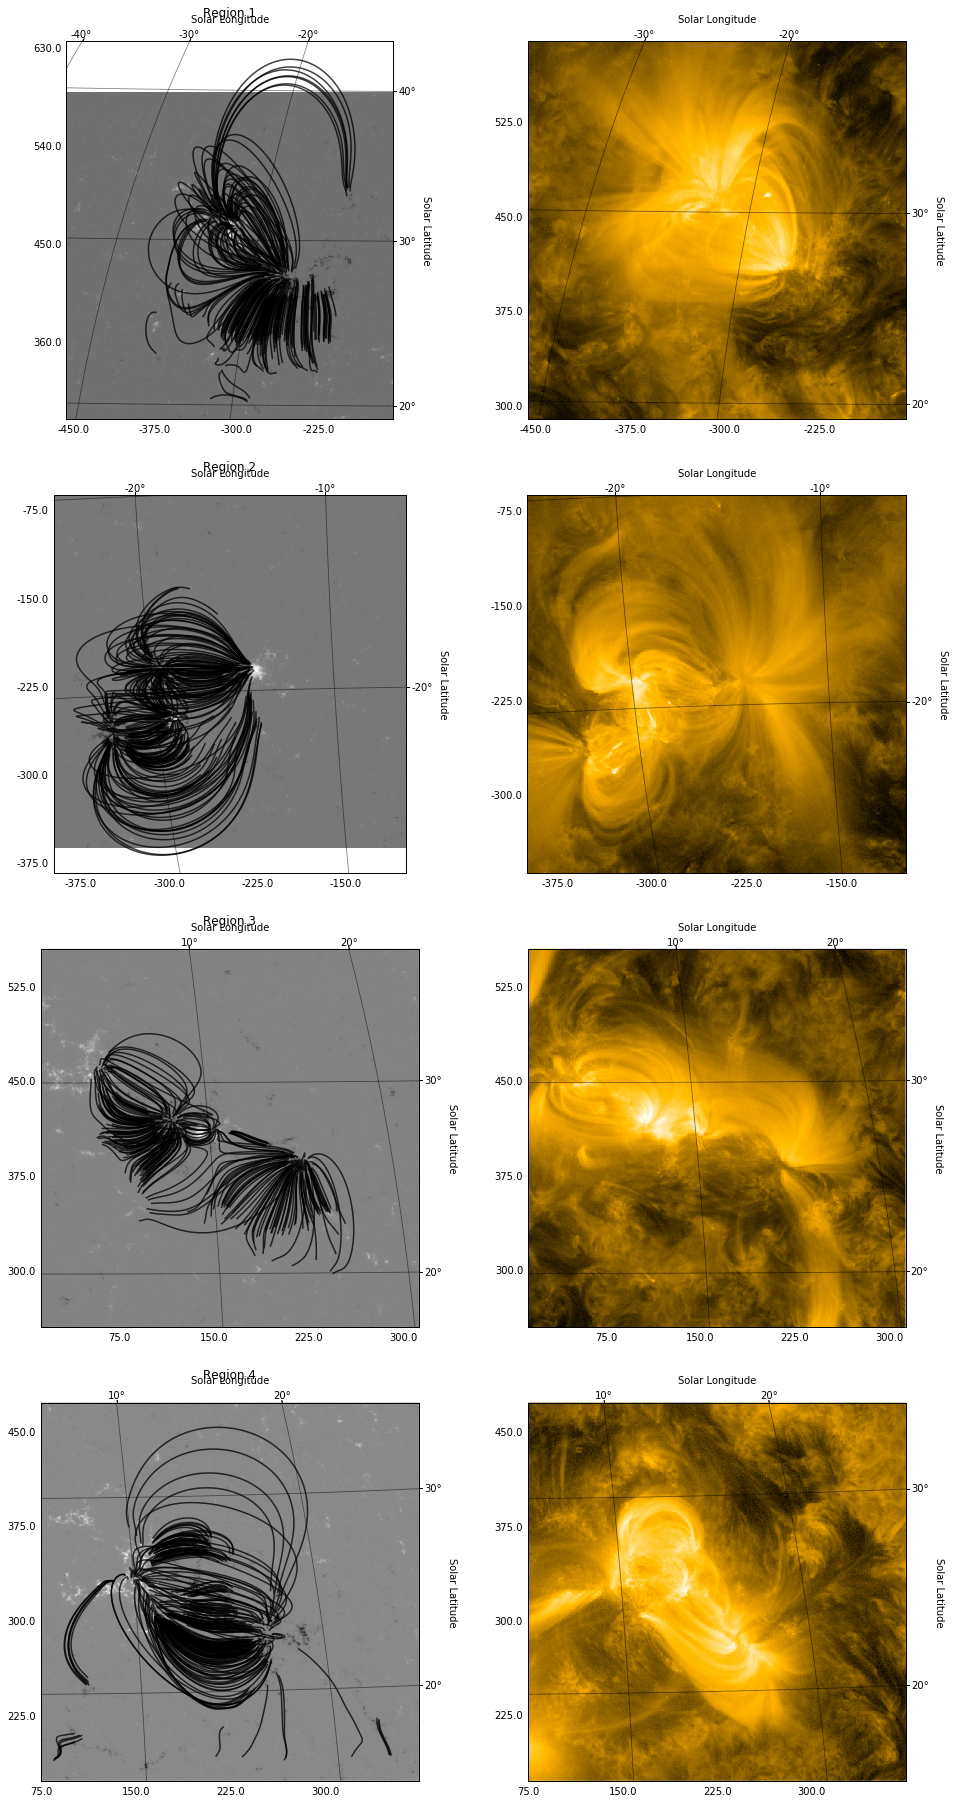

In [26]:
img_width = 8
fig = plt.figure(figsize=(img_width*2,img_width*4))
for i,row in enumerate(ar_catalogue[:4]):
    print('Plotting Region {}'.format(row['Region']))
    ### HMI ###
    tmp_map = Map(row['HMI_File']).rotate()
    blc = SkyCoord(row['X_cen']-w_x/2, row['Y_cen']-w_y/2, frame = tmp_map.coordinate_frame)
    trc = SkyCoord(row['X_cen']+w_x/2, row['Y_cen']+w_y/2, frame = tmp_map.coordinate_frame)
    tmp_map = tmp_map.submap(blc, trc)
    ax = fig.add_subplot(4,2,2*i+1,projection=tmp_map)
    tmp_map.plot(axes=ax,annotate=False,title=False)
    tmp_map.draw_grid(grid_spacing=10 * u.deg,color='k',axes=ax)
    ax.coords[0].grid(alpha=0)
    ax.coords[1].grid(alpha=0)
    ax.set_title('Region {}'.format(row['Region']))
    # plot streamlines
    for line,_ in lines_list[i]:
        coord = heeq_to_hcc_coord(line[:,0], line[:,1], line[:,2],
                                  observer_coordinate=tmp_map.observer_coordinate).transform_to(tmp_map.coordinate_frame)
        ax.plot_coord(coord,alpha=0.75,color='k')

    ### AIA ###
    tmp_map = Map(row['AIA_File'])
    blc = SkyCoord(row['X_cen']-w_x/2, row['Y_cen']-w_y/2, frame = tmp_map.coordinate_frame)
    trc = SkyCoord(row['X_cen']+w_x/2, row['Y_cen']+w_y/2, frame = tmp_map.coordinate_frame)
    tmp_map = tmp_map.submap(blc, trc)
    ax = fig.add_subplot(4,2,2*(i+1),projection=tmp_map)
    tmp_map.plot(axes=ax,annotate=False,title=False)
    tmp_map.draw_grid(grid_spacing=10 * u.deg,color='k',axes=ax)
    ax.coords[0].grid(alpha=0)
    ax.coords[1].grid(alpha=0)

We can also visualize the extrapolated field with `yt`. Let's try these for each of our regions and overplot some fieldlines on top.

In [ ]:
mag_fields = ['Bx','By','Bz']
fig = plt.figure()
grid = AxesGrid(fig, (0.075,0.075,0.85,0.85),
                nrows_ncols = (5, 3),
                axes_pad = 1.2,
                label_mode = "1",
                share_all = False,
                cbar_location="right",
                cbar_mode="each",
                cbar_size="3%",
                cbar_pad="0%")
fig.set_figwidth(25)
for i,field in enumerate(skeleton_list):
    p = yt.ProjectionPlot(field.extrapolated_3d_field,'z',mag_fields,origin='center-domain',axes_unit='cm')
    p.annotate_streamlines('Bx','By')
    p.figure_size = 30
    plot = p.plots['Bz']
    plot.figure = fig
    plot.axes = grid[i].axes
    plot.cax = grid.cbar_axes[i]
    p._setup_plots()

## Zooming In
After looking over several of the extrapolated fields and comparing with the 171 Å intensity, we've selected a subset of the ARs: 1,2,3,5,9,10. We now want to adjust the FOV for each of these, increase the number of fieldlines we trace through the volume, and compare with the 193 Å intensity as well.

In [ ]:
first_round_picks = ar_catalogue[(ar_catalogue['Region'] == '1') 
                                   | (ar_catalogue['Region'] == '2')
                                   | (ar_catalogue['Region'] == '3') 
                                   | (ar_catalogue['Region'] == '5')
                                   | (ar_catalogue['Region'] == '9')
                                   | (ar_catalogue['Region'] == '10')
                                ]

In [ ]:
first_round_picks

In [ ]:
aia_193_files = []

In [ ]:
for row in first_round_picks:
    print('Querying data for region #{}'.format(row['Region']))
    # query
    ### AIA
    dt = 10
    start_time = convert_npdt_to_str(row['Date'] - np.timedelta64(dt,'s'))
    end_time = convert_npdt_to_str(row['Date'] + np.timedelta64(dt,'s'))
    q_aia_193 = client.query(
        vso.attrs.Time(start_time,end_time),
        vso.attrs.Instrument('AIA'),
        vso.attrs.Wave(193*u.angstrom,193*u.angstrom)
    )
    print(q_aia_193)
    aia_193_res = client.get(q_aia_193,path=os.path.join(obs_data_loc,'{file}')).wait()
    aia_193_files.append(aia_193_res[0])

In [ ]:
first_round_picks['AIA File'].name =  'AIA 171 File'
first_round_picks['AIA 193 File'] = aia_193_files

Refine FOV selection. Expand and recenter the regions of opposite polarity. Make sure there is enough room on the outside for the loops.

In [ ]:
resample_resolution = u.Quantity([100,100]*u.pixel)
zshape = 100
number_of_lines = 1000

In [ ]:
first_round_picks['X range'] = [
    u.Quantity([-420,-170],u.arcsec),
    u.Quantity([-400,-190],u.arcsec),
    u.Quantity([0,350],u.arcsec),
    u.Quantity([-600,-375],u.arcsec),
    u.Quantity([125,575],u.arcsec),
    u.Quantity([-150,250],u.arcsec)
]
first_round_picks['X range'].unit = u.arcsec
first_round_picks['Y range'] = [
    u.Quantity([320,570],u.arcsec),
    u.Quantity([-335,-125],u.arcsec),
    u.Quantity([230,580],u.arcsec),
    u.Quantity([-375,-150],u.arcsec),
    u.Quantity([50,500],u.arcsec),
    u.Quantity([150,550],u.arcsec)
]
first_round_picks['Y range'].unit = u.arcsec

In [ ]:
first_round_picks[1]['Y range']

Do the field extrapolations.

In [ ]:
first_round_skeletons = []

In [ ]:
for row in first_round_picks[3:]:
    print('Extrapolating field for region {}'.format(row['Region']))
    field = synthesizAR.Skeleton(hmi_fits_file=row['HMI File'],
                                 crop=(row['X range'],row['Y range']),
                                 resample=resample_resolution)
    delta_x = np.diff(row['X range'])[0]
    delta_y = np.diff(row['Y range'])[0]
    field.extrapolate_field(zshape=zshape,
                            zrange=u.Quantity([-10.*u.arcsec,max(delta_x,delta_y)]))
    field.extract_streamlines(number_of_lines)
    first_round_skeletons.append(field)

Finally, plot everything again.

In [ ]:
img_width = 8
fig = plt.figure(figsize=(img_width*3,img_width*6))
for i,(row,field) in enumerate(zip(first_round_picks,first_round_skeletons)):
    print('Plotting Region {}'.format(row['Region']))
    ### HMI ###
    tmp_map = Map(row['HMI File'])
    tmp_map = tmp_map.rotate()
    tmp_map = tmp_map.submap(row['X range'],row['Y range'])
    ax = fig.add_subplot(6,3,3*i+1,projection=tmp_map)
    tmp_map.plot(axes=ax,annotate=False)
    ax.coords[0].grid(alpha=0)
    ax.coords[1].grid(alpha=0)
    ax.set_title('SDO/HMI LOS Magnetogram')
    # plot streamlines
    for stream, _ in field.streamlines:
        ax.plot(field._convert_angle_to_length(stream[:, 0]*u.cm,working_units=u.arcsec).to(u.deg),
                field._convert_angle_to_length(stream[:, 1]*u.cm,working_units=u.arcsec).to(u.deg),
                alpha=0.2,color=sns.color_palette()[0],transform=ax.get_transform('world'))

    ### AIA ###
    # 171
    tmp_map = Map(row['AIA 171 File'])
    tmp_map = tmp_map.submap(row['X range'],row['Y range'])
    ax = fig.add_subplot(6,3,3*i+2,projection=tmp_map)
    tmp_map.plot(axes=ax,annotate=False,)
    ax.coords[0].grid(alpha=0)
    ax.coords[1].grid(alpha=0)
    ax.set_title('Region {}, NOAA {}\nSDO/AIA 171 Å'.format(row['Region'],row['NOAA']))
    # 193
    tmp_map = Map(row['AIA 193 File'])
    tmp_map = tmp_map.submap(row['X range'],row['Y range'])
    ax = fig.add_subplot(6,3,3*(i+1),projection=tmp_map)
    tmp_map.plot(axes=ax,annotate=False,)
    ax.coords[0].grid(alpha=0)
    ax.coords[1].grid(alpha=0)
    ax.set_title('SDO/AIA 193 Å')

In [ ]:
# plot streamlines
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
for stream, _ in first_round_skeletons[1].streamlines:
    ax.plot(stream[:, 1],stream[:, 2],alpha=0.1,color=sns.color_palette()[0])
ax.set_ylim([0,5.5e9])
ax.set_xlim([-1.8e10,-1.4e10])